<h2 style="text-align: center;"><span style="color: #333399;">Lab Course: Distributed Data Analytics</span><br /><span style="color: #333399;">Exercise Sheet 6</span></h2>
<h3 style="text-align: center;"><span style="color: #333399;">Syed Wasif Murtaza Jafri- 311226</span></h3>

## Exercise 1: PyTorch Network Analysis
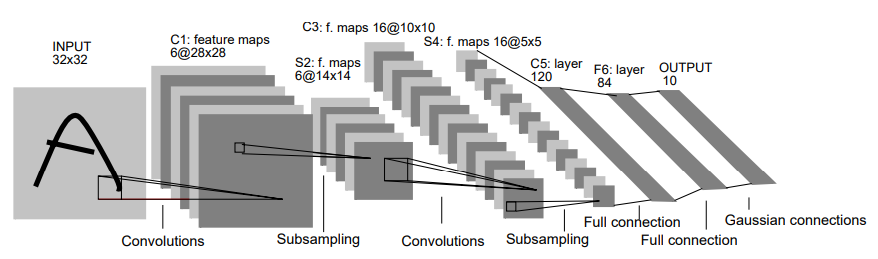

In [12]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader,Dataset  # Gives easier dataset managment by creating mini batches etc.
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
import warnings
warnings.filterwarnings('ignore')

In [21]:
class LeNetCNN(nn.Module):
    def __init__(self, input_channels=1, num_of_classes=10):
        super(LeNetCNN, self).__init__()
        self.relu = nn.ReLU()

        self.C1 = nn.Conv2d(
            in_channels = input_channels,
            out_channels = 6,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
            
        )
        self.S2 = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.C3 = nn.Conv2d(
            in_channels = 6,
            out_channels = 16,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
        )
        self.S4 = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.C5 = nn.Conv2d(
            in_channels = 16,
            out_channels = 120,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
        )
        self.F6 = nn.Linear(120,84)
        self.OUTPUT = nn.Linear(84,num_of_classes)
        
    def forward(self,x):
  
        x = self.relu(self.C1(x)) # dimension after : [1, 6, 28, 28]

        x = self.S2(x) # dimension after : [1, 6, 14, 14]
        x = self.relu(self.C3(x))  # dimension after : [1, 16,10, 10]
        x = self.S4(x)  # dimension after : [1, 16, 5, 5]
        x = self.relu(self.C5(x))  # dimension after : [1, 120, 1, 1]
        
        # flattening dimension (120,1,1) to 120
        x = x.view(-1, 120 * 1 * 1)  # dimension after : [1, 120]
        
        x = self.relu(self.F6(x))  # dimension after : [1, 84]
        x = self.OUTPUT(x)  # dimension after : [1, 10]

        
        return x
        

### Mnist Dataset

In [40]:
def accuracy(outputs, labels):
    ''' Calculating accuray of prediction'''
    
    _, preds = torch.max(outputs, dim = 1) # class with highest probablity is the predicted output
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_total_steps = len(train_loader)
in_channels = 1 # input channels of image
num_classes = 10 # number of output class [0-10]
num_epochs = 50
batch_size= 128
# resizing image for LasNet
transform = transforms.Compose([transforms.Resize((32,32)),
    transforms.ToTensor()
])

# getting training and test data
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transform)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size ,shuffle=True)

# different setting of learning rates
learning_rate = [0.1,0.01,0.001]
criterion = nn.CrossEntropyLoss()

for lr in learning_rate:
    
    # Initialize network
    model = LeNetCNN(input_channels=in_channels, num_of_classes=num_classes).to(device)
    
    # Initializing Optimizer
    optimizer= torch.optim.SGD(model.parameters(),lr=lr)
    
    # Initializing writer for tensorboard
    writer = SummaryWriter()
    
    print('--------------------------------------------------')
    print('|------Experiment with learning rate = '+str(lr)+'--------|')
    print('--------------------------------------------------')

    for epoch in range(num_epochs):
        
        # iterating through all batches
        for i,sample_batched in enumerate(train_loader):
            
            # setting gradient to zero before forward pass
            optimizer.zero_grad()
            
            # model predict
            yhat=model(sample_batched[0].cuda())
            
            # model loss
            loss=criterion(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            
            # model accuracy
            acc = accuracy(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            
            # writing accuracy and loss to tensorboard logs
            writer.add_scalar("Loss/train", loss, epoch)
            writer.add_scalar("Accuracy/train",acc, epoch)
            
            # calculating gradient through backprop
            loss.backward(retain_graph=True)
            
            # updating parameters
            optimizer.step()
            
        if (epoch+1) % 15 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    writer.flush()
    print('Finished Training')
    
    # for evaluating model on test data with no gradient calculation
    with torch.no_grad():
        for i,sample_batched in enumerate(test_loader):
            # setting gradient to zero before forward pass
            optimizer.zero_grad()
            
            # model predict
            yhat=model(sample_batched[0].cuda())
            
            # model loss
            loss=criterion(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            
            # model acc
            acc = accuracy(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            
            # writing accuracy and loss to tensorboard logs
            writer.add_scalar("Loss/test", loss, epoch)
            writer.add_scalar("Accuracy/test", acc, epoch)
    
    writer.flush()

cuda
--------------------------------------------------
|------Experiment with learning rate = 0.1--------|
--------------------------------------------------
Epoch [15/50], Loss: 0.0044
Epoch [30/50], Loss: 0.0002
Epoch [45/50], Loss: 0.0001
Finished Training
--------------------------------------------------
|------Experiment with learning rate = 0.01--------|
--------------------------------------------------
Epoch [15/50], Loss: 0.0632
Epoch [30/50], Loss: 0.0675
Epoch [45/50], Loss: 0.0498
Finished Training
--------------------------------------------------
|------Experiment with learning rate = 0.001--------|
--------------------------------------------------
Epoch [15/50], Loss: 2.3003
Epoch [30/50], Loss: 0.6418
Epoch [45/50], Loss: 0.3758
Finished Training


### Graphs on tensorboard for different learning rates
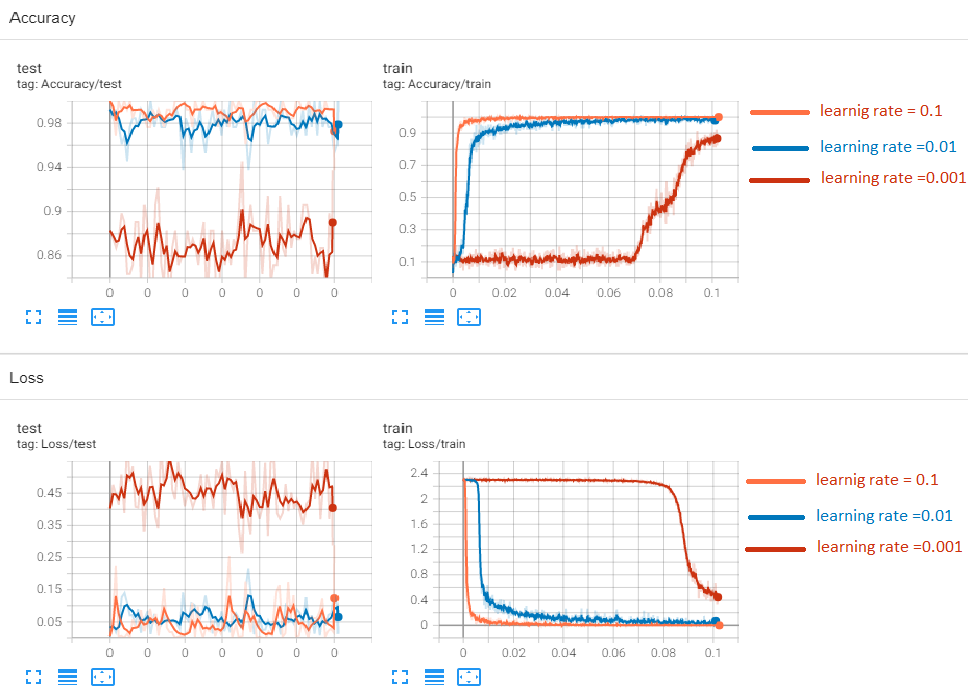

# Bonus
## kernal size = 5

In [41]:
class LeNetCNNkernal5(nn.Module):
    def __init__(self, input_channels=1, num_of_classes=10):
        super(LeNetCNNkernal5, self).__init__()
        self.relu = nn.ReLU()

        self.C1 = nn.Conv2d(
            in_channels = input_channels,
            out_channels = 6,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
            
        )
        self.S2 = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.C3 = nn.Conv2d(
            in_channels = 6,
            out_channels = 16,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
        )
        self.S4 = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.C5 = nn.Conv2d(
            in_channels = 16,
            out_channels = 120,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
        )
        self.F6 = nn.Linear(120,84)
        self.OUTPUT = nn.Linear(84,num_of_classes)
        
    def forward(self,x):
  
        x = self.relu(self.C1(x)) # dimension after : [1, 6, 28, 28]

        x = self.S2(x) # dimension after : [1, 6, 14, 14]
        x = self.relu(self.C3(x))  # dimension after : [1, 16,10, 10]
        x = self.S4(x)  # dimension after : [1, 16, 5, 5]
        x = self.relu(self.C5(x))  # dimension after : [1, 120, 1, 1]
        
        # flattening dimension (120,1,1) to 120
        x = x.view(-1, 120 * 1 * 1)  # dimension after : [1, 120]
        
        x = self.relu(self.F6(x))  # dimension after : [1, 84]
        x = self.OUTPUT(x)  # dimension after : [1, 10]

        
        return x

# Initialize network
model = LeNetCNNkernal5(input_channels=in_channels, num_of_classes=num_classes).to(device)

# Initializing Optimizer
optimizer= torch.optim.SGD(model.parameters(),lr=lr)

# Initializing writer for tensorboard
writer = SummaryWriter()

images ,_ = next(iter(train_loader)) 
writer.add_graph(model, images.cuda())
#writer.close()
#sys.exit()


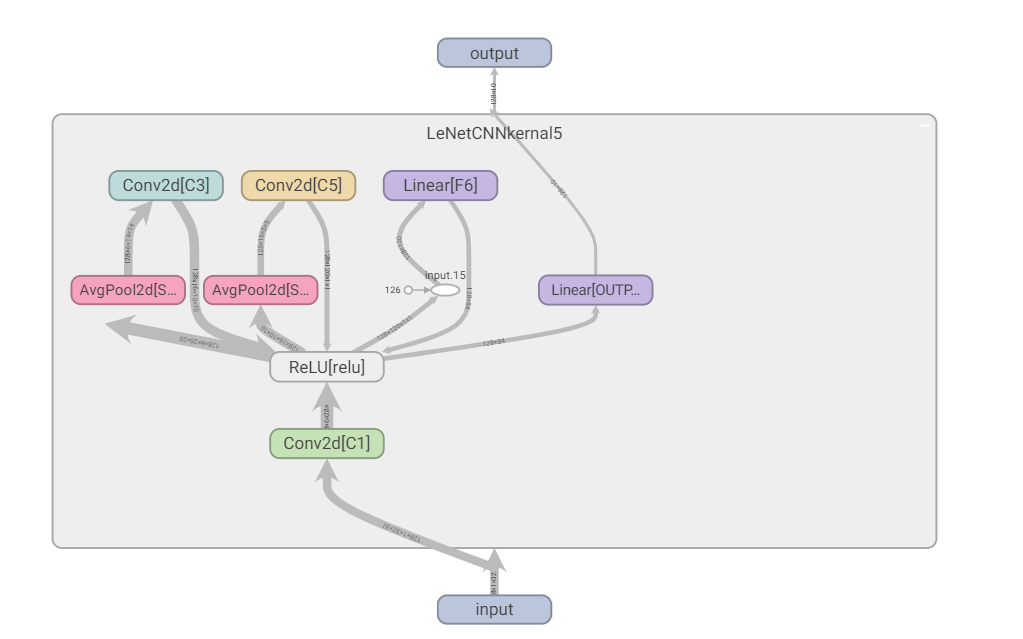
## kernal size = 3

In [42]:
class LeNetCNNkernal3(nn.Module):
    def __init__(self, input_channels=1, num_of_classes=10):
        super(LeNetCNNkernal3, self).__init__()
        self.relu = nn.ReLU()

        self.C1 = nn.Conv2d(
            in_channels = input_channels,
            out_channels = 6,
            kernel_size = (3,3),
            stride=(1,1),
            padding=(0,0)
            
        )
        self.S2 = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.C3 = nn.Conv2d(
            in_channels = 6,
            out_channels = 16,
            kernel_size = (3,3),
            stride=(1,1),
            padding=(0,0)
        )
        self.S4 = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.C5 = nn.Conv2d(
            in_channels = 16,
            out_channels = 120,
            kernel_size = (3,3),
            stride=(1,1),
            padding=(0,0)
        )
        self.F6 = nn.Linear(1920,84)
        self.OUTPUT = nn.Linear(84,num_of_classes)
        
    def forward(self,x):
  
        x = self.relu(self.C1(x)) # dimension after : [128, 6, 30, 30]
        x = self.S2(x) # dimension after : [128, 6, 15, 15]
        x = self.relu(self.C3(x))  # dimension after : [128, 16, 13, 13]
        x = self.S4(x)  # dimension after : [128, 16, 6, 6]
        x = self.relu(self.C5(x))  # dimension after : [128, 120, 4, 4]
        # flattening dimension (120,1,1) to 120
        x = x.view(-1, 120 * 4 * 4)  # dimension after : [128, 1920]
        x = self.relu(self.F6(x))  # dimension after : [1, 84]
        x = self.OUTPUT(x)  # dimension after : [1, 10]
        
        return x

# Initialize network
model = LeNetCNNkernal3(input_channels=in_channels, num_of_classes=num_classes).to(device)

# Initializing Optimizer
optimizer= torch.optim.SGD(model.parameters(),lr=lr)

# Initializing writer for tensorboard
writer = SummaryWriter()

images ,_ = next(iter(train_loader)) 
writer.add_graph(model, images.cuda())
#writer.close()
#sys.exit()


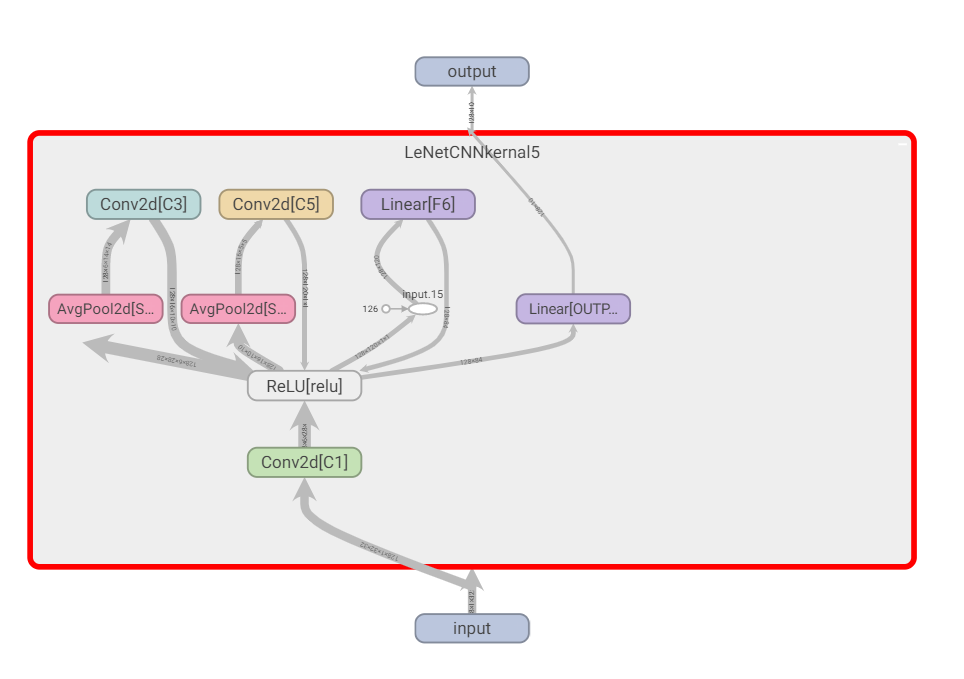
#### Only linear layer size is changed after changing kernal size from 5 to 3

## CIFAR-10

In [44]:
def accuracy(outputs, labels):
    ''' Calculating accuray of prediction'''
    
    _, preds = torch.max(outputs, dim = 1) # class with highest probablity is the predicted output
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

in_channels = 3 # input channels of image
num_classes = 10 # number of output class [0-10]
num_epochs = 150
batch_size= 128
# resizing image for LasNet
transform = transforms.Compose([transforms.Resize((32,32)),
    transforms.ToTensor()
])

# getting training and test data
train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transform)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size ,shuffle=True)

# different setting of learning rates
learning_rate = [0.1,0.01,0.001]
n_total_steps = len(train_loader)
criterion = nn.CrossEntropyLoss()

for lr in learning_rate:
    
    # Initialize network
    model = LeNetCNN(input_channels=in_channels, num_of_classes=num_classes).to(device)
    
    # Initializing Optimizer
    optimizer= torch.optim.SGD(model.parameters(),lr=lr)
    
    # Initializing writer for tensorboard
    writer = SummaryWriter()
    
    print('--------------------------------------------------')
    print('|------Experiment with learning rate = '+str(lr)+'--------|')
    print('--------------------------------------------------')

    for epoch in range(num_epochs):
        
        # iterating through all batches
        for i,sample_batched in enumerate(train_loader):
            
            # setting gradient to zero before forward pass
            optimizer.zero_grad()
            
            # model predict
            yhat=model(sample_batched[0].cuda())
            
            # model loss
            loss=criterion(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            
            # model accuracy
            acc = accuracy(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            
            # writing accuracy and loss to tensorboard logs
            writer.add_scalar("Loss/train", loss, epoch)
            writer.add_scalar("Accuracy/train",acc, epoch)
            
            # calculating gradient through backprop
            loss.backward(retain_graph=True)
            
            # updating parameters
            optimizer.step()
            
        if (epoch+1) % 15 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    writer.flush()
    print('Finished Training')
    
    # for evaluating model on test data with no gradient calculation
    with torch.no_grad():
        for i,sample_batched in enumerate(test_loader):
            # setting gradient to zero before forward pass
            optimizer.zero_grad()
            
            # model predict
            yhat=model(sample_batched[0].cuda())
            
            # model loss
            loss=criterion(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            
            # model acc
            acc = accuracy(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())
            
            # writing accuracy and loss to tensorboard logs
            writer.add_scalar("Loss/test", loss, epoch)
            writer.add_scalar("Accuracy/test", acc, epoch)
    
    writer.flush()

cuda
--------------------------------------------------
|------Experiment with learning rate = 0.1--------|
--------------------------------------------------
Epoch [15/150], Loss: 0.9115
Epoch [30/150], Loss: 0.8349
Epoch [45/150], Loss: 0.6723
Epoch [60/150], Loss: 0.7676
Epoch [75/150], Loss: 0.5176
Epoch [90/150], Loss: 0.4347
Epoch [105/150], Loss: 0.3696
Epoch [120/150], Loss: 0.4013
Epoch [135/150], Loss: 0.2907
Epoch [150/150], Loss: 0.1642
Finished Training
--------------------------------------------------
|------Experiment with learning rate = 0.01--------|
--------------------------------------------------
Epoch [15/150], Loss: 1.6544
Epoch [30/150], Loss: 1.6142
Epoch [45/150], Loss: 1.3918
Epoch [60/150], Loss: 1.2303
Epoch [75/150], Loss: 1.1960
Epoch [90/150], Loss: 1.0780
Epoch [105/150], Loss: 1.0866
Epoch [120/150], Loss: 0.8507
Epoch [135/150], Loss: 1.0318
Epoch [150/150], Loss: 0.9307
Finished Training
--------------------------------------------------
|------Expe

### Graphs on tensorboard for different learning rates
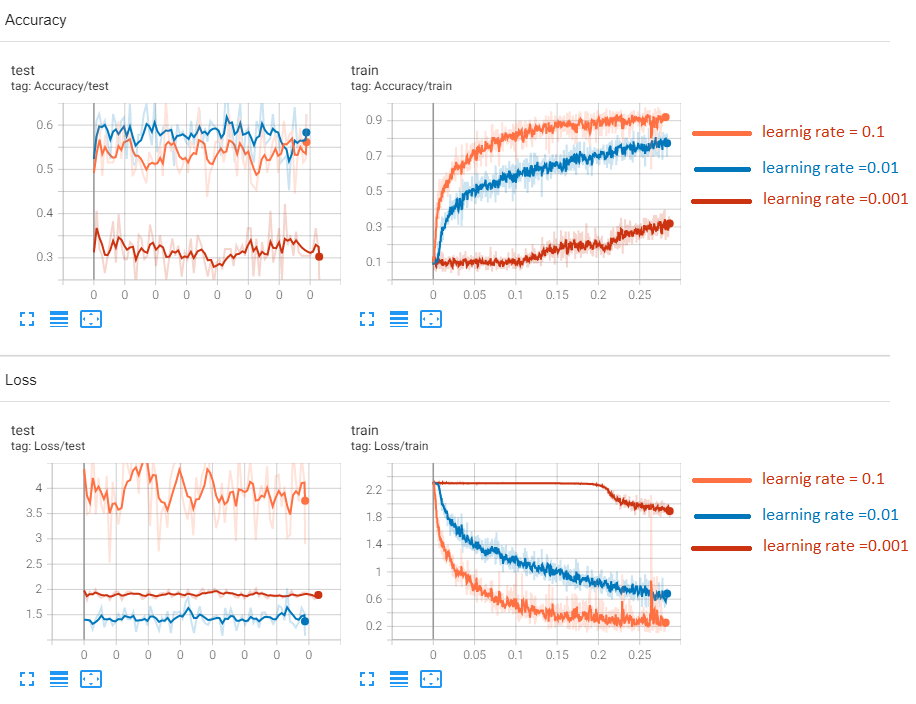

## Exercise 2: Custom Task

### Transforming mnist to custom dataset

In [45]:
import random
import numpy as np
class MnistDataset(Dataset):
    ''''''
    def __init__(self, k,train=True,transform = transforms.Compose([transforms.ToTensor()])):
        
        self.k = k # k images added together
        self.train = train  # training dataset of not
        self.transform = transform # for transformation
        self.dataset = datasets.MNIST(root="dataset/",train = self.train, transform=self.transform) # loading Minist dataset
        self.indices = range(len(self.dataset)) # indices of all dataset


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        k_images_index = random.sample(self.indices, self.k)  # picking k random indices
        outx = []
        output = np.zeros((32,32*self.k))
        sum_digit = 0
        i=0
        
        for index in k_images_index: # iterating k indices
            
            images1, labels1 = self.dataset[index]
            sum_digit += labels1 # adding labels of k images
            outx.append(images1) # puting all k tensors in a list
            i+=1
        
        result= torch.stack(outx, 0) # stacking all tensors into one
        return result,torch.tensor(sum_digit)# returing stacked tensors and summed label

In [46]:
# loading training data
transform = transforms.Compose([transforms.Resize((32,32)),
    transforms.ToTensor()
])
train_dataset= MnistDataset(k=5,train=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                   )


### Verifying new dataset

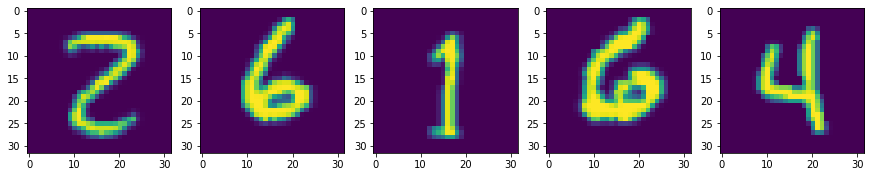

Dataset label: tensor(19)


In [47]:
# testing one sample of dataset and ploting each k image in sample and printing assigned label
images, lable = train_dataset[0]

fig = plt.figure(figsize=(15, 8))
for i in range(len(images)):
    image = images[i]
    
    # for ploting changing position of channel : (h,w,c)
    tensor_image = image.view(image.shape[1], image.shape[2], image.shape[0])
    fig.add_subplot(1, len(images), i+1)
    plt.imshow(tensor_image)
plt.show()

print('Dataset label:',lable)

### LesNet for Regression

In [48]:

class LeNetReg(nn.Module):
    def __init__(self, input_channels=1,k=1):
        super(LeNetReg, self).__init__()
        self.relu = nn.ReLU()
        self.identity = nn.Identity()

        self.C1 = nn.Conv2d(
            in_channels = input_channels*k,
            out_channels = 6,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
            
        )
        self.S2 = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.C3 = nn.Conv2d(
            in_channels = 6,
            out_channels = 16,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
        )
        self.S4 = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.C5 = nn.Conv2d(
            in_channels = 16,
            out_channels = 120,
            kernel_size = (5,5),
            stride=(1,1),
            padding=(0,0)
        )
        self.F6 = nn.Linear(120,84)
        self.F7 = nn.Linear(84,1)
        
        
    def forward(self,x):
        N,K,C,W,H = x.shape
        x = x.view(N,K*C,W,H)
        x = self.relu(self.C1(x)) # dimension after : [N, 6, 28, 28]
        x = self.S2(x) # dimension after : [N, 6, 14, 14]
        x = self.relu(self.C3(x))  # dimension after : [N, 16,10, 10]
        x = self.S4(x)  # dimension after : [N, 16, 5, 5]
        x = self.relu(self.C5(x))  # dimension after : [N, 120, 1, 1]

        x = x.view(N, 120)

        x = self.relu(self.F6(x))  # dimension after : [N, 84]
        x = self.F7(x)  # dimension after : [N, 1]
        # Output layer with activation function

 

        return x.to(torch.float32)

In [49]:
# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

in_channels = 1 # input channels of image
num_classes = 10 # number of output class [0-10]
num_epochs = 20
batch_size= 256
k=5
# resizing image for LasNet
transform = transforms.Compose([transforms.Resize((32,32)),
    transforms.ToTensor()
])

# getting training and test data
train_dataset = MnistDataset(k=k, train=True, transform=transform)
test_dataset = MnistDataset(k=k, train=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size ,shuffle=True)


# different setting of learning rates
learning_rate = [0.01]
n_total_steps = len(train_loader)
criterion = nn.MSELoss()
for lr in learning_rate:
    
    # Initialize network
    model = LeNetReg(input_channels=in_channels,k=k).to(device)
    
    # Initializing Optimizer
    optimizer= torch.optim.RMSprop(model.parameters(),lr=lr)

    # Initializing writer for tensorboard
    writer = SummaryWriter()
    
    

    
    print('--------------------------------------------------')
    print('|------Experiment with learning rate = '+str(lr)+'--------|')
    print('--------------------------------------------------')

    for epoch in range(num_epochs):
        mse = 0
        # iterating through all batches
        for i,sample_batched in enumerate(train_loader):
            
            # setting gradient to zero before forward pass
            optimizer.zero_grad()
            
            # model predict
            yhat=model(sample_batched[0].cuda())
            
            # model loss
            loss=criterion(yhat.float().squeeze().cuda(),sample_batched[1].float().squeeze().cuda()).to(torch.float32)
            rmse= torch.sqrt(torch.sum(loss)/len(sample_batched[1]))
            
            # writing accuracy and loss to tensorboard logs
            writer.add_scalar("RMSE Loss/train", rmse, epoch)

            
            # calculating gradient through backprop
            loss.backward(retain_graph=True)
            
            # updating parameters
            optimizer.step()

            
        if (epoch+1) % 2 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {rmse.item():.4f}')

    writer.flush()
    print('Finished Training')
    
    # for evaluating model on test data with no gradient calculation
    with torch.no_grad():
        for i,sample_batched in enumerate(test_loader):
            # setting gradient to zero before forward pass
            optimizer.zero_grad()
            
            # model predict
            yhat=model(sample_batched[0].cuda())
            
            # model loss
            loss=criterion(yhat.squeeze().cuda(),sample_batched[1].squeeze().cuda())

            # writing accuracy and loss to tensorboard logs
            writer.add_scalar("RMSE Loss/test", loss, epoch)

    writer.flush()

cuda
--------------------------------------------------
|------Experiment with learning rate = 0.01--------|
--------------------------------------------------
Epoch [2/20], Loss: 0.5735
Epoch [4/20], Loss: 0.4742
Epoch [6/20], Loss: 0.5831
Epoch [8/20], Loss: 0.4636
Epoch [10/20], Loss: 0.4863
Epoch [12/20], Loss: 0.4534
Epoch [14/20], Loss: 0.4447
Epoch [16/20], Loss: 0.4311
Epoch [18/20], Loss: 0.4793
Epoch [20/20], Loss: 0.4833
Finished Training


<ul>
<li>
<h3> Train/Test Error on Tensorboard
    </h3>
</li>
</ul>


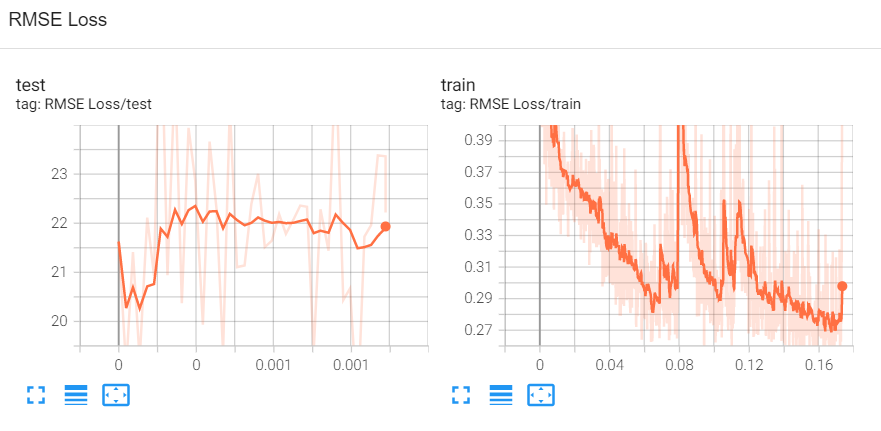

<ul>
<li>
<h3>10 sets of test images (each set containing K many images) and the output from your trainednetwork (final value that your model outputs)</h3>
</li>
</ul>

--------------------------------------------------
|------Test Set = 1--------|
--------------------------------------------------


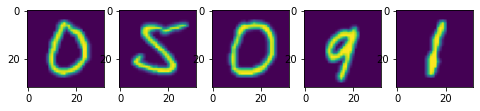

Actual label: 15 Predicted label: 15.192828178405762
--------------------------------------------------
|------Test Set = 2--------|
--------------------------------------------------


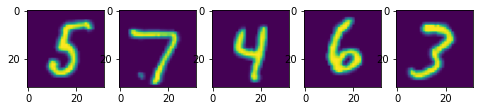

Actual label: 25 Predicted label: 22.843265533447266
--------------------------------------------------
|------Test Set = 3--------|
--------------------------------------------------


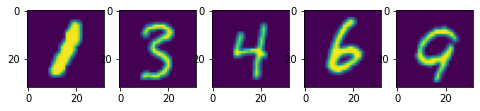

Actual label: 23 Predicted label: 21.709625244140625
--------------------------------------------------
|------Test Set = 4--------|
--------------------------------------------------


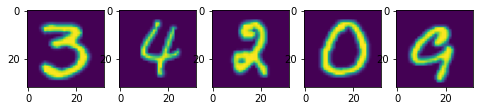

Actual label: 18 Predicted label: 11.92827033996582
--------------------------------------------------
|------Test Set = 5--------|
--------------------------------------------------


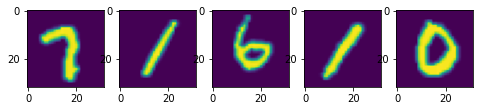

Actual label: 15 Predicted label: 19.992156982421875
--------------------------------------------------
|------Test Set = 6--------|
--------------------------------------------------


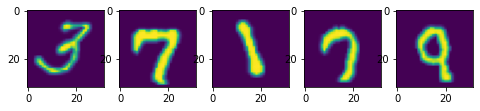

Actual label: 27 Predicted label: 26.386764526367188
--------------------------------------------------
|------Test Set = 7--------|
--------------------------------------------------


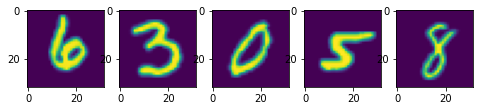

Actual label: 22 Predicted label: 19.25542449951172
--------------------------------------------------
|------Test Set = 8--------|
--------------------------------------------------


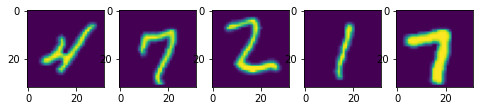

Actual label: 21 Predicted label: 24.562204360961914
--------------------------------------------------
|------Test Set = 9--------|
--------------------------------------------------


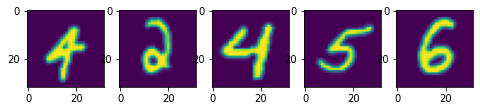

Actual label: 21 Predicted label: 24.452823638916016
--------------------------------------------------
|------Test Set = 10--------|
--------------------------------------------------


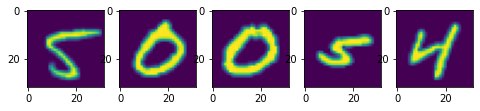

Actual label: 14 Predicted label: 17.297073364257812


In [50]:
with torch.no_grad():
    for i in range(10):
        images, lable = test_dataset[i]
        yhat=model(images.unsqueeze(0).cuda())
        print('--------------------------------------------------')
        print('|------Test Set = ' +str(i+1)+'--------|')
        print('--------------------------------------------------')
        fig = plt.figure(figsize=(8, 6))
        for i in range(len(images)):
            image = images[i]
            
            # for ploting changing position of channel : (h,w,c)
            tensor_image = image.view(image.shape[1], image.shape[2], image.shape[0])
            fig.add_subplot(1, len(images), i+1)
            plt.imshow(tensor_image)
        plt.show()
        
        print('Actual label:',lable.item(),'Predicted label:',yhat.item())